In [ ]:
import pandas as pd
import re
import numpy as np
import math

import scipy.sparse as sparse
from ast import literal_eval
import time
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

!pip install boto3
!pip install s3fs
import boto3
from botocore.client import Config
import s3fs 
import os

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_tags = []
for i in range(14):
  all_tags.append(pd.read_csv(f'/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/tags csv files/keywords_match_cleaned_{i}_13.csv'))
tags = pd.concat(all_tags)
tags

,Unnamed: 0,word1,word2,consine_score,fuzz_score
0,0,'ppc.advck','advck',0.564603,78
1,1,'whconv','whconv1',0.745728,94
2,2,'wcunlink','unlinked',0.349683,80
3,3,'wcunlink','wclink',0.425299,89
4,4,'advck082619','advck090919',0.504998,77
...,...,...,...,...,...
13604,13604,'959711779','956471177',0.375468,82
13605,13605,'959816964','956816960',0.380566,82
13606,13606,'960076235','956506235',0.314763,82
13607,13607,'mtf2015','mtf2014',0.791455,89


In [ ]:
tags['digit'] = tags.word1.apply(lambda x: True if re.match(r'^\'\d+\'$',x) else False)
tags = tags[~tags.digit].copy()
tags['digit']= tags.word2.apply(lambda x: True if re.match(r'^\'\d+\'$',x) else False)
tags = tags[~tags.digit].copy()
tags['schedule'] = tags.word1.apply(lambda x: "schedulereleaseemail" in x)
tags = tags[~tags.schedule].copy()
tags['schedule'] = tags.word2.apply(lambda x: "schedulereleaseemail" in x)
tags = tags[~tags.schedule].copy()

In [ ]:
subgraph_tags = pd.read_excel('/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/reclustered_tags.xlsx')
subgraph_tags = subgraph_tags[['subgraph_0','subgraph_1','subgraph_10','subgraph_11','subgraph_12']]
subgraph_tags

,subgraph_0,subgraph_1,subgraph_10,subgraph_11,subgraph_12
0,'ppc.advck','wb00sea','fb16_renew_linked_011916','fb15_renew_unlinked_031115','fb15_donate_linked_063015'
1,'advck','bb91sea','fb16_mp_linked_060116','fb16_renew_unlinked_011916','fb15_donate_linked_070115'
2,'advck090919','fb92sea','fb16_renew_linked_031416','fb16_renew_unlinked_020916','fb15okdondue4'
3,'advck091119','wb02sea','sglinked','fb16_mp_unlinked_060116','fb14donor'
4,'advck103119','fb11studsea','fb11_papps_linked','fb15_renew_unlinked_031615','donlwnd4'
...,...,...,...,...,...
1481,NaN,'camp2015gymnastics',NaN,NaN,NaN
1482,NaN,'camp2013gymnastics',NaN,NaN,NaN
1483,NaN,'camp2018gymnastics',NaN,NaN,NaN
1484,NaN,'camp2017gymnastics',NaN,NaN,NaN


In [ ]:
tags_set = set()
for i in subgraph_tags.columns.tolist():
  for j in subgraph_tags[i].tolist():
    tags_set.add(j)
len(tags_set)

1686

In [ ]:
acc_counts_per_tag = pd.read_csv('/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/account_counts_per_tag.csv')
acc_counts_per_tag

In [ ]:
tags_set2 = set()
for i in acc_counts_per_tag['tag'].tolist():
  tags_set2.add(i)

In [ ]:
#tags = tags.drop(['Unnamed: 0'],axis=1)
def check_tag(x,s):
  return x.word1 in s and x.word2 in s

In [ ]:
tags['kept'] = tags.apply(check_tag,args=(tags_set2,),axis=1)
tags = tags[tags['kept']==True]
tags

,Unnamed: 0,word1,word2,consine_score,fuzz_score,kept
0,0,'ppc.advck','advck',0.564603,78,True
4,4,'advck082619','advck090919',0.504998,77,True
5,5,'advck082619','advck091119',0.510706,77,True
6,6,'advck082619','advck092619',0.671948,92,True
7,7,'advck082619','advck103119',0.386118,77,True
...,...,...,...,...,...,...
5333,5333,'camp2018baseball','camp2015basketball',0.442748,89,True
5334,5334,'camp2018baseball','camp2013basketball',0.444377,89,True
5335,5335,'camp2018baseball','camp2018basketball',0.708567,95,True
5336,5336,'camp2018baseball','camp2018football',0.459170,78,True


In [ ]:
def match4digits(s):
  regex1 = re.match(r'^[a-z]{3}\d{4}', s.word1)
  if regex1:
    regex1_year = int(s.word1[3:7])
    if regex1_year < 2010:
      return False
  regex2 = re.match(r'^[a-z]{3}\d{4}', s.word2)
  if regex2:
    regex2_year = int(s.word2[3:7])
    if regex2_year < 2010:
      return False
  return True


def match2digits(s):
  regex1 = re.match(r'^[a-z]{2}\d{2}', s.word1)
  if regex1:
    regex1_year = int(s.word1[2:4])
    if regex1_year < 10 or regex1_year > 21:
      return False
  regex2 = re.match(r'^[a-z]{2}\d{2}', s.word2)
  if regex2:
    regex2_year = int(s.word2[2:4])
    if regex2_year < 10 or regex2_year > 21:
      return False
  return True

In [ ]:
tags['4digits'] = tags.apply(match4digits,axis=1)
tags['2digits'] = tags.apply(match2digits,axis=1)
tags = tags[(tags['4digits']==True) & (tags['2digits']==True)]
tags

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,word1,word2,consine_score,fuzz_score,kept,4digits,2digits
0,0,'ppc.advck','advck',0.564603,78,True,True,True
4,4,'advck082619','advck090919',0.504998,77,True,True,True
5,5,'advck082619','advck091119',0.510706,77,True,True,True
6,6,'advck082619','advck092619',0.671948,92,True,True,True
7,7,'advck082619','advck103119',0.386118,77,True,True,True
...,...,...,...,...,...,...,...,...
5333,5333,'camp2018baseball','camp2015basketball',0.442748,89,True,True,True
5334,5334,'camp2018baseball','camp2013basketball',0.444377,89,True,True,True
5335,5335,'camp2018baseball','camp2018basketball',0.708567,95,True,True,True
5336,5336,'camp2018baseball','camp2018football',0.459170,78,True,True,True


In [ ]:
tagwithorgs = pd.read_csv('/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/tagwithorgs.csv')
tagwithorgs.columns = ['index','tag','org_id']

for row in tagwithorgs.itertuples():
  rowindex = getattr(row,'index')
  tagwithorgs.loc[rowindex,'org_id1'] = list(eval(tagwithorgs.iloc[rowindex].org_id))[0]

org_color_map = dict()
for i in tagwithorgs.org_id1.unique():
  org_color_map[i] = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
            
org_color_map

{'ARKANSAS': '#2F774D',
 'ARMY': '#123F30',
 'CLEMSON': '#A86BAA',
 'COLORADO': '#6242DB',
 'ECU': '#ADF3BD',
 'FRESNO': '#3188B6',
 'FSU': '#C803F6',
 'IOWA': '#A4238C',
 'KANSAS': '#65C1CE',
 'LSU': '#3497F6',
 'MICH': '#C5C7F2',
 'MSSTATE': '#0D5A69',
 'NCSU': '#5F2926',
 'NEBRASKA': '#BA7E54',
 'OKLAHOMA': '#B6A7F3',
 'TAM': '#4BEE67',
 'TTU': '#3F1691',
 'USC': '#216EF0',
 'UT-A': '#BFCF82',
 'WASHINGTON': '#1976FD'}

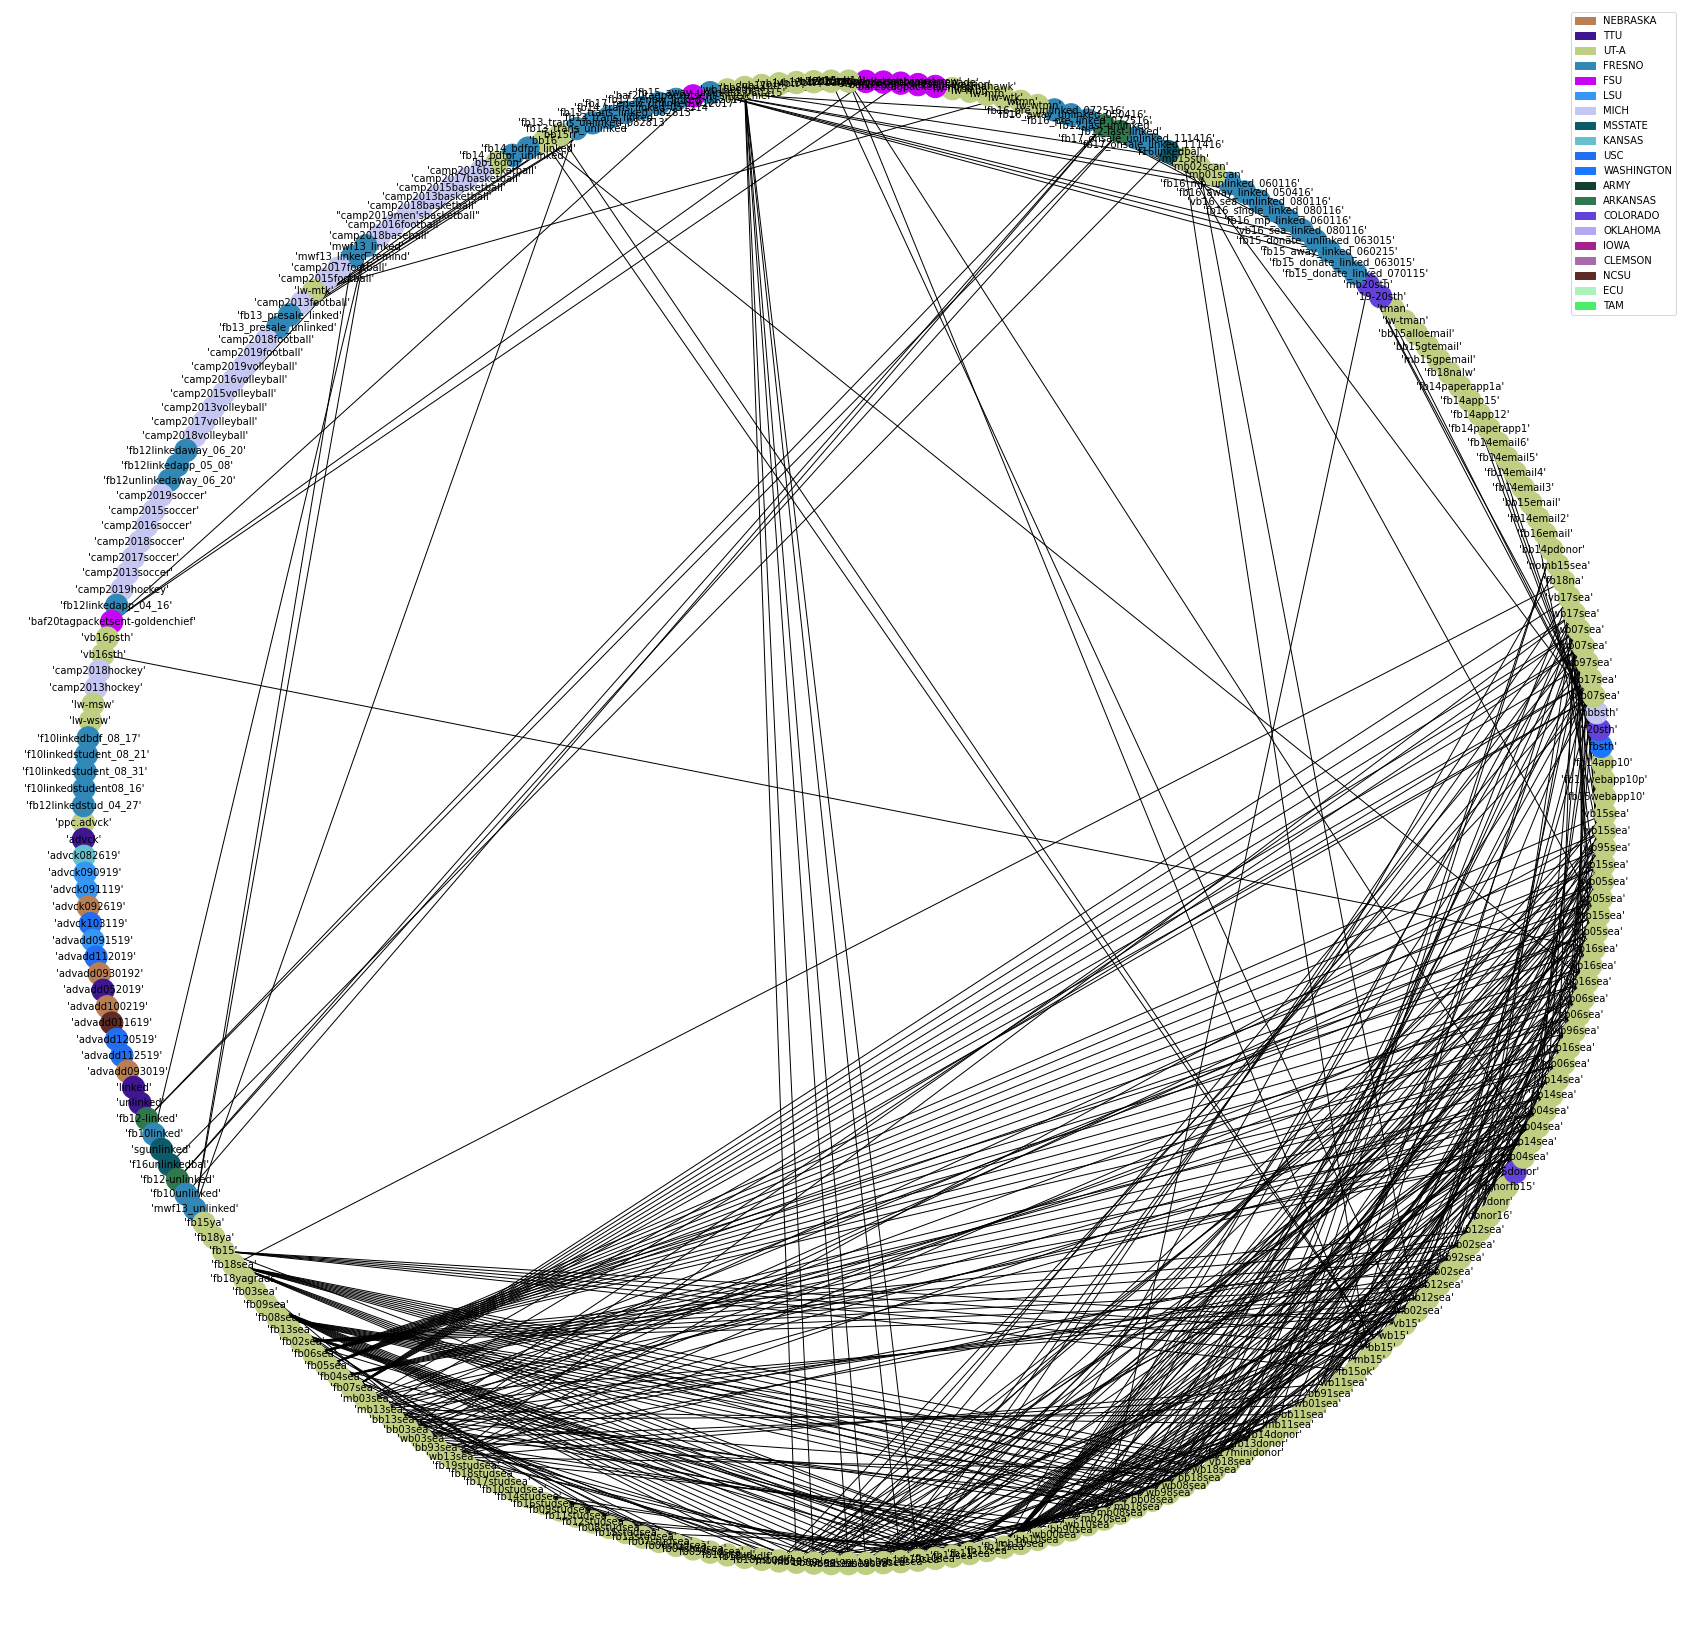

In [ ]:
fig , ax1 = plt.subplots(figsize=(30,30))
# nx.draw_networkx
# draw_kamada_kawai
G = nx.from_pandas_edgelist(tags,
                       source = "word1",
                      target = "word2")
nodes = G.nodes()
colors = []
for n in nodes:
  org = tagwithorgs.loc[tagwithorgs.tag == n,'org_id1'].iloc[0]
  colors.append(org_color_map[org])

nx.draw_shell(G, with_labels=True, font_size = 10, node_size = 500, node_color= colors)

handle = [mpatches.Patch(color=v, label=k) for k,v in org_color_map.items() ]
plt.legend(handles=handle)
plt.savefig('/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/tagnetwork_colored',bbox_inches='tight')

plt.show()


In [ ]:
sub_graphs = nx.algorithms.components.connected_components(G)

#n gives the number of sub graphs
# n = len(sub_graphs)

# you can now loop through all nodes in each sub graph
for i,graph_i in enumerate(sub_graphs):
    print(i,"Subgraph:", graph_i)

0 Subgraph: {"'advck'", "'ppc.advck'"}
1 Subgraph: {"'judywhconv'", "'whconv'", "'whconv1'"}
2 Subgraph: {"'fb16_mp_linked_060116'", "'fb15_renew_linked_040315'", "'mwf13_unlinked'", "'fb15_renew_unlinked_032615'", "'wclink'", "'fb16_away_linked_050416'", "'fb17_onsale_linked_111416'", "'fb12-last-unlinked'", "'fb10unlinked2'", "'fb12-last-linked'", "'fb13_trans_linked'", "'unscanned_unlinked_040317'", "'fb16_renew_linked_032816'", "'fb16_renew_unlinked_032116'", "'fb17_renew_unlinked_031317'", "'sglinked'", "'fb15_renew_unlinked_031615'", "'fb17_renew_unlinked_012017'", "'fb14_sthpr_unlinked'", "'fb17_renew_linked_040617'", "'fb17_renew_unlinked_032917'", "'f16linkedbal'", "'fb16_renew_linked_032116'", "'bdf_cal_link'", "'unscanned_linked_032817'", "'fb16_renew_linked_011916'", "'mwf13_unlinked_extend'", "'fb14_trans_unlinked_051314'", "'fb15_away_linked_060215'", "'fb15_renew_unlinked_040315'", "'fb11_papps_unlinked'", "'fb16_away_unlinked_050416'", "'f16unlinkedbal'", "'fb17_stud_un

In [ ]:
acc_counts_per_sub = pd.read_csv('/content/drive/Shareddrives/STATS170AB-Paciolan/data/outputs/account_counts_per_sub.csv')
acc_counts_per_sub = acc_counts_per_sub.drop(['Unnamed: 0'],axis=1)
acc_counts_per_sub = acc_counts_per_sub.sort_values('acc_counts',ascending=False)
acc_counts_per_sub

,sub_graph,acc_counts
0,0,1036741
1,1,922950
13,13,210458
10,10,164596
12,12,124864
11,11,119818
3,3,62478
2,2,60861
4,4,12464
5,5,6564


In [ ]:
acc_counts_per_sub['tag_format'] = ['advance check','sports+year+season', 'email','sports+date_linked','donation',
                                   'sports+date_unlinked','sports event+app','sports+gender',
                                  'tagpacketsent','2020/21ack','gtw','alumni','coach','wheel','children'
                                  ]
acc_counts_per_sub

,sub_graph,acc_counts,tag_format
0,0,1036741,advance check
1,1,922950,sports+year+season
13,13,210458,email
10,10,164596,sports+date_linked
12,12,124864,donation
11,11,119818,sports+date_unlinked
3,3,62478,sports event+app
2,2,60861,sports+gender
4,4,12464,tagpacketsent
5,5,6564,2020/21ack


In [ ]:
import plotly.express as px

In [ ]:
fig = px.bar(acc_counts_per_sub, x='tag_format', y='acc_counts',
             color_discrete_sequence=["#FFDC5A"],width=800, height=500, text='acc_counts',
             title = 'Total Number of Accounts per Sub-section of Tags (filtered by tagging format)')
fig.update_traces(texttemplate='%{text:.1s}', textposition='outside')
fig.show()

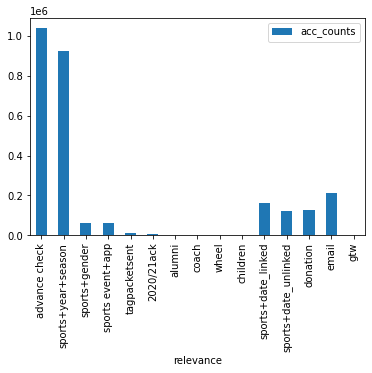

In [ ]:
acc_counts_per_sub.plot(kind='bar',x='relevance',y='acc_counts')
plt.show()